##### <h1 style="color:Green;">Week 4 Lecture Source Code</h1> 

<a style="color:purple;" href="https://docs.google.com/presentation/d/1_jQKSrS4hiVJaxnFYhRh284AhAbPxI0CL0qAP4Iz-DE/edit#slide=id.p">[Week 4 Lecture Link Here]</a>

<h2 style="color:Green;">Setup and Loading Packages</h2> Setup and Loading Packages

In [35]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_multilabel_classification
import pandas_datareader as pdr

What is Classification?

Classification is a supervised learning concept that uses one or more predictors (features, independent variables) to categorize a set of data into classes. This concept can be applied to solve two-class or multi-class calssification problems, in real-world scenarios such as:

• Identifying economic cycles (e.g., expansion, peak, through, recession)

• Classifying credit card transactions as legitimate or fraudulent

• Classifying market strend structures as uptrend, congestion, downtrend

• Categorizing news stories of finance as having positive, neutral, or negative sentiments

• Recognizing handwritten checks and digits as one of {A, B, C, …, Z, 0, 1, ... 9}

• Assigning trading attributes to their origin of cause (e.g., Greece, UK, Russia)


Note that different assumptiosn are made for each classification model.

<h2 style="color:Green;">Simulated Data (pg. 3)</h2>

<b> Example of a Binary Classification Problem </b>

Let's use the data we processed from last lecture. This contains sector ETFs, XLK (Technology) and IYC (Consumer Discretionary), as well as SPY (S&P 500) directions from 1/25/2018 to 5/31/2022, a total of 1086 trading days.

In [62]:
DATA1 = pd.read_csv('SPY_XLK_IYC.csv')
DATA1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086 entries, 0 to 1085
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1086 non-null   object 
 1   SPY     1086 non-null   float64
 2   XLK     1086 non-null   float64
 3   IYC     1086 non-null   float64
dtypes: float64(3), object(1)
memory usage: 34.1+ KB


In [64]:
# converting SPY log returns into binary values 1's and 0's
DATA1['SPY Direction'] = (DATA1.SPY > 0).astype(int)

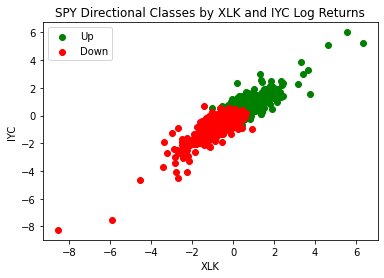

In [70]:
plt.scatter(DATA1.XLK[DATA1['SPY Direction'] == 1],
            DATA1.IYC[DATA1['SPY Direction'] == 1],
           color='green',
           label='Up')
plt.scatter(DATA1.XLK[DATA1['SPY Direction'] == 0],
            DATA1.IYC[DATA1['SPY Direction'] == 0],
           color='red',
           label='Down')
plt.title('SPY Directional Classes by XLK and IYC Log Returns')
plt.xlabel('XLK')
plt.ylabel('IYC')
plt.legend()
plt.show()

From the scatter plot, besides a fairly strong linear relationship, we can see that the data points are divided into red and green colors, green representing an upward direction in SPY and red represeneting a downward direction in SPY. One of the most popular problems in quantitative finance is to find a classifier (model) that most-accurately separates the data points that indicates an upward move from those that indicate a downward move. Through this model, we will be able to predict under any given conditions of XLK and IYC log returns, which direction would SPY be expected to move in the next trading day. 

<b> Example of a Multi-class Classification Problem </b>

Note that here, we split the data by their quantiles just so each of the 4 classes can dominate roughly 25% of the data set, hence making the data set less biased and eliminating the label imbalance issue.

In [88]:
# categorizing SPY returns into 2 directional classes
multiInterval = [DATA1.SPY.min(), DATA1.SPY.quantile(.25), 0, DATA1.SPY.quantile(.75), DATA1.SPY.max()]
multiLabels   = ['major loss','minor loss','minor gain','major gain']
DATA1['SPY Return Type'] = pd.cut(DATA1.SPY, bins = multiInterval, labels=multiLabels)

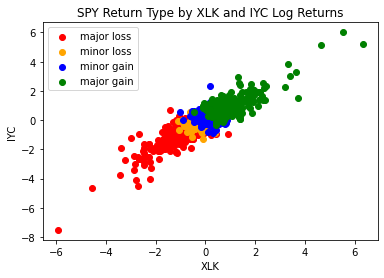

In [78]:
plt.scatter(DATA1.XLK[DATA1['SPY Return Type'] == 'major loss'],
            DATA1.IYC[DATA1['SPY Return Type'] == 'major loss'],
           color='red',
           label='major loss')
plt.scatter(DATA1.XLK[DATA1['SPY Return Type'] == 'minor loss'],
            DATA1.IYC[DATA1['SPY Return Type'] == 'minor loss'],
           color='orange',
           label='minor loss')
plt.scatter(DATA1.XLK[DATA1['SPY Return Type'] == 'minor gain'],
            DATA1.IYC[DATA1['SPY Return Type'] == 'minor gain'],
           color='blue',
           label='minor gain')
plt.scatter(DATA1.XLK[DATA1['SPY Return Type'] == 'major gain'],
            DATA1.IYC[DATA1['SPY Return Type'] == 'major gain'],
           color='green',
           label='major gain')

plt.title('SPY Return Type by XLK and IYC Log Returns')
plt.xlabel('XLK')
plt.ylabel('IYC')
plt.legend()
plt.show()

This is a multi-class classification problem, one that consists of > 2 SPY return type classes. Be aware that we are no longer evaluating the asset's directional, but rather the magnitude of its daily gains/losses. Our goall is fond the classifier (model) of multiple lines that most-accurately separate the SPY return type into their corresponding classes.

<h2 style="color:Green;">Exploring the Trading Factors Data (pg. XX)</h2>

Here, we examine the trading signals of the top 500 most-traded stock in the U.S. from 1/21/2013 to 9/30/2017. This data set was originally used to indicate market behaviors in the U.S. during the European struggles such as the Greece's debt crisis in 2015 and Brexit in 2017. One of the behaviors is the fluctuation of market participants, and a way to measure this is through trading volumes, in other words, the transactions of assets throughout a period in time. In our case, we will be looking at monthly volumes, specifically how they are classified to imply low, medium, or high liquidity. 


Our goal is to use the trading factors to help train the classification models to predict market liquidity. The utilization of this is to inform the concentration of the selected market a trader is trading in. We start by loading the data set and categorizing volumes into 3 respective liquidity classes.

In [135]:
DATA2 = pd.read_csv('trading_factors_data.csv')
DATA2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31437 entries, 0 to 31436
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ticker      31437 non-null  object 
 1   sector      31437 non-null  object 
 2   date        31437 non-null  object 
 3   open        31437 non-null  float64
 4   close       31437 non-null  float64
 5   high        31437 non-null  float64
 6   low         31437 non-null  float64
 7   open_close  31437 non-null  float64
 8   high_low    31437 non-null  float64
 9   volume      31437 non-null  float64
 10  atr         31437 non-null  float64
 11  macd        31437 non-null  float64
 12  rsi         31437 non-null  float64
 13  bb_high     31437 non-null  float64
 14  bb_low      31437 non-null  float64
 15  bb_mid      31437 non-null  float64
dtypes: float64(13), object(3)
memory usage: 3.8+ MB


In [136]:
# categorizing volumes into 3 liquidity classes
multiInterval = [0, DATA2.volume.quantile(.25), DATA2.volume.quantile(.75), DATA2.volume.max()]
multiLabels   = ['Low','Medium','High']
DATA2['liquidity'] = pd.cut(DATA2.volume, bins = multiInterval, labels=multiLabels)

As an example, we have ploted the stocks' liquidity class by the indicators open_close vs bb_mid.

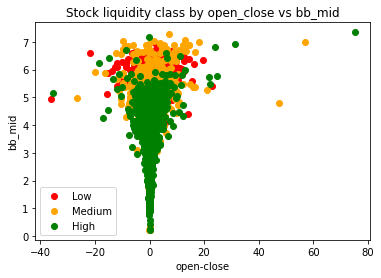

In [139]:
plt.scatter(DATA2['open_close'][DATA2.liquidity == 'Low'],
            DATA2['bb_mid'][DATA2.liquidity == 'Low'],
           color='red',
           label='Low')
plt.scatter(DATA2['open_close'][DATA2.liquidity == 'Medium'],
            DATA2['bb_mid'][DATA2.liquidity == 'Medium'],
           color='orange',
           label='Medium')
plt.scatter(DATA2['open_close'][DATA2.liquidity == 'High'],
            DATA2['bb_mid'][DATA2.liquidity == 'High'],
           color='green',
           label='High')

plt.title('Stock liquidity class by open_close vs bb_mid')
plt.xlabel('open-close')
plt.ylabel('bb_mid')
plt.legend()
plt.show()